- Loading libraries and Data

In [262]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from fancyimpute import IterativeImputer, IterativeSVD, KNN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [263]:
from regressors import stats

In [264]:
df = pd.read_csv('kidney_disease.csv')
print(f'Data dimensions: {df.shape}')
#to eliminate the id and to have only one index
df.drop('id', inplace = True, axis = 1)

Data dimensions: (400, 26)


- Rename columns

In [265]:
#rename columns
df.rename(columns={'bp':'blood pressure','sg':'specific_gravity', 'al':'albumin','su':'sugar', 'rbc':'red_blood_cells',
                        'pc':'pus_cell','pcc':'pus_cell_clumps',
                        'ba':'bacteria','bgr':'blood_glucose_random','bu':'blood_urea','sc':'serum_creatinine',
                        'sod':'sodium','pot':'potassium','hemo':'hemoglobin', 'pcv':'packed_cell_volume',
                        'wc':'white_blood_cell_count','rc':'red_blood_cell_count','htn':'hypertension',
                        'dm':'diabetes_mellitus', 'cad':'coronary_artery_disease','appet':'appetite',
                        'pe':'pedal_edema','ane':'anemia'}, inplace = True)
df.head(4)

,age,blood pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd


Replace non numerical values and null values with "NaN"

In [266]:
df['red_blood_cell_count'].value_counts().to_frame()

,red_blood_cell_count
5.2,18
4.5,16
4.9,14
4.7,11
4.8,10
3.9,10
4.6,9
3.4,9
5.9,8
5.5,8


In [267]:
df['coronary_artery_disease'].replace('\tno', 'no', inplace=True)
df['diabetes_mellitus'].replace('\tyes', 'yes', inplace=True)
df['diabetes_mellitus'].replace(' yes', 'yes', inplace=True)
df['diabetes_mellitus'].replace('\tno', 'no', inplace=True)

Conversion to use categorical variables

In [268]:
df = pd.get_dummies(df, columns=['hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'anemia'], drop_first=True)
columns = df.columns
print(columns)

Index(['age', 'blood pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'hemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count', 'appetite',
       'pedal_edema', 'classification', 'hypertension_yes',
       'diabetes_mellitus_yes', 'coronary_artery_disease_yes', 'anemia_yes'],
      dtype='object')


Replace 'NaN' values by np.nan values

In [269]:
columns_object_type = ['packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count']
for column in columns_object_type:
    df[column].replace('NaN', np.nan, inplace=True)
    #Eliminate those values diferent than integer and NaN 
    df.drop(df[df['packed_cell_volume']=='\t?'].index, inplace=True)
    df[column] = df['packed_cell_volume'].astype(float)
    df[column].value_counts().to_frame()

In [270]:
df['classification'].replace('ckd\t', 'ckd', inplace=True)

#### Univariate analysis

<Axes: xlabel='albumin', ylabel='age'>

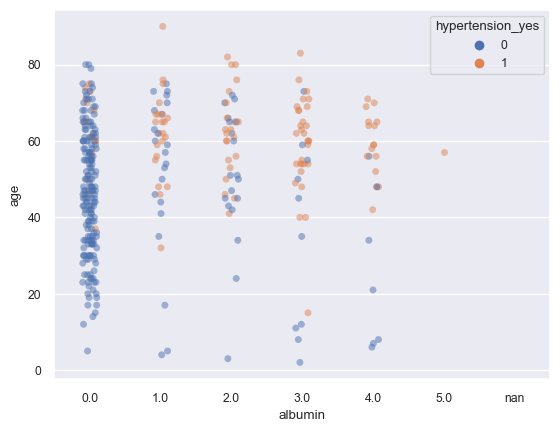

In [271]:
sns.stripplot(data=df, x='albumin', y='age', hue='hypertension_yes', alpha=0.5)

<Axes: xlabel='classification', ylabel='blood_urea'>

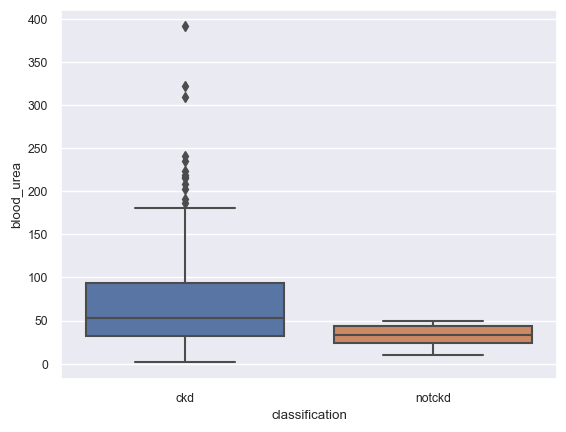

In [272]:
sns.boxplot(data=df, x='classification', y='blood_urea')

<Axes: xlabel='red_blood_cell_count', ylabel='classification'>

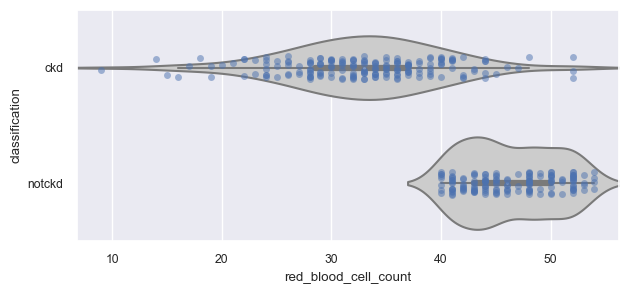

In [273]:
plt.figure(figsize=(7,3))
sns.violinplot(data=df, x='red_blood_cell_count', y='classification', color='0.8')
sns.stripplot(data=df, x='red_blood_cell_count', y='classification', alpha=0.5)

Find out correlations

C:\Users\loren\AppData\Local\Temp\ipykernel_6704\527458535.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask1 = np.triu(np.ones_like(df.corr()))


<Axes: >

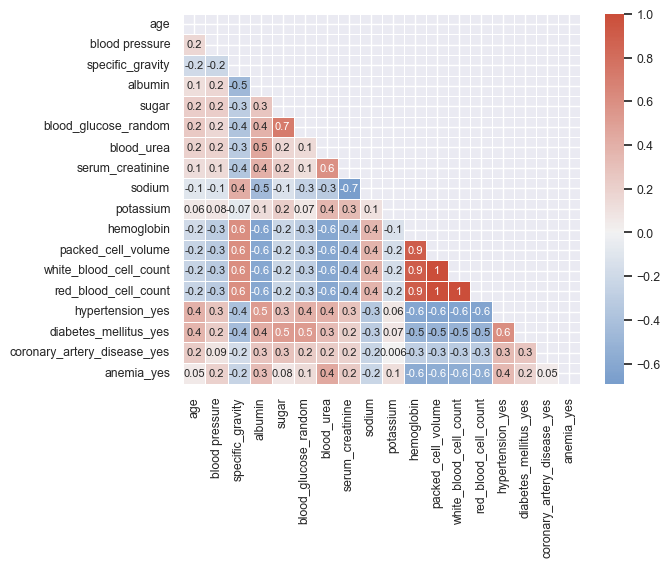

In [274]:
mask1 = np.triu(np.ones_like(df.corr()))
cmap1 = sns.diverging_palette(250, 17, as_cmap=True)
sns.heatmap(df.corr(), fmt='.1g', mask=mask1, annot=True, cmap=cmap1, center=0, linewidths=.5, annot_kws={"fontsize":8})

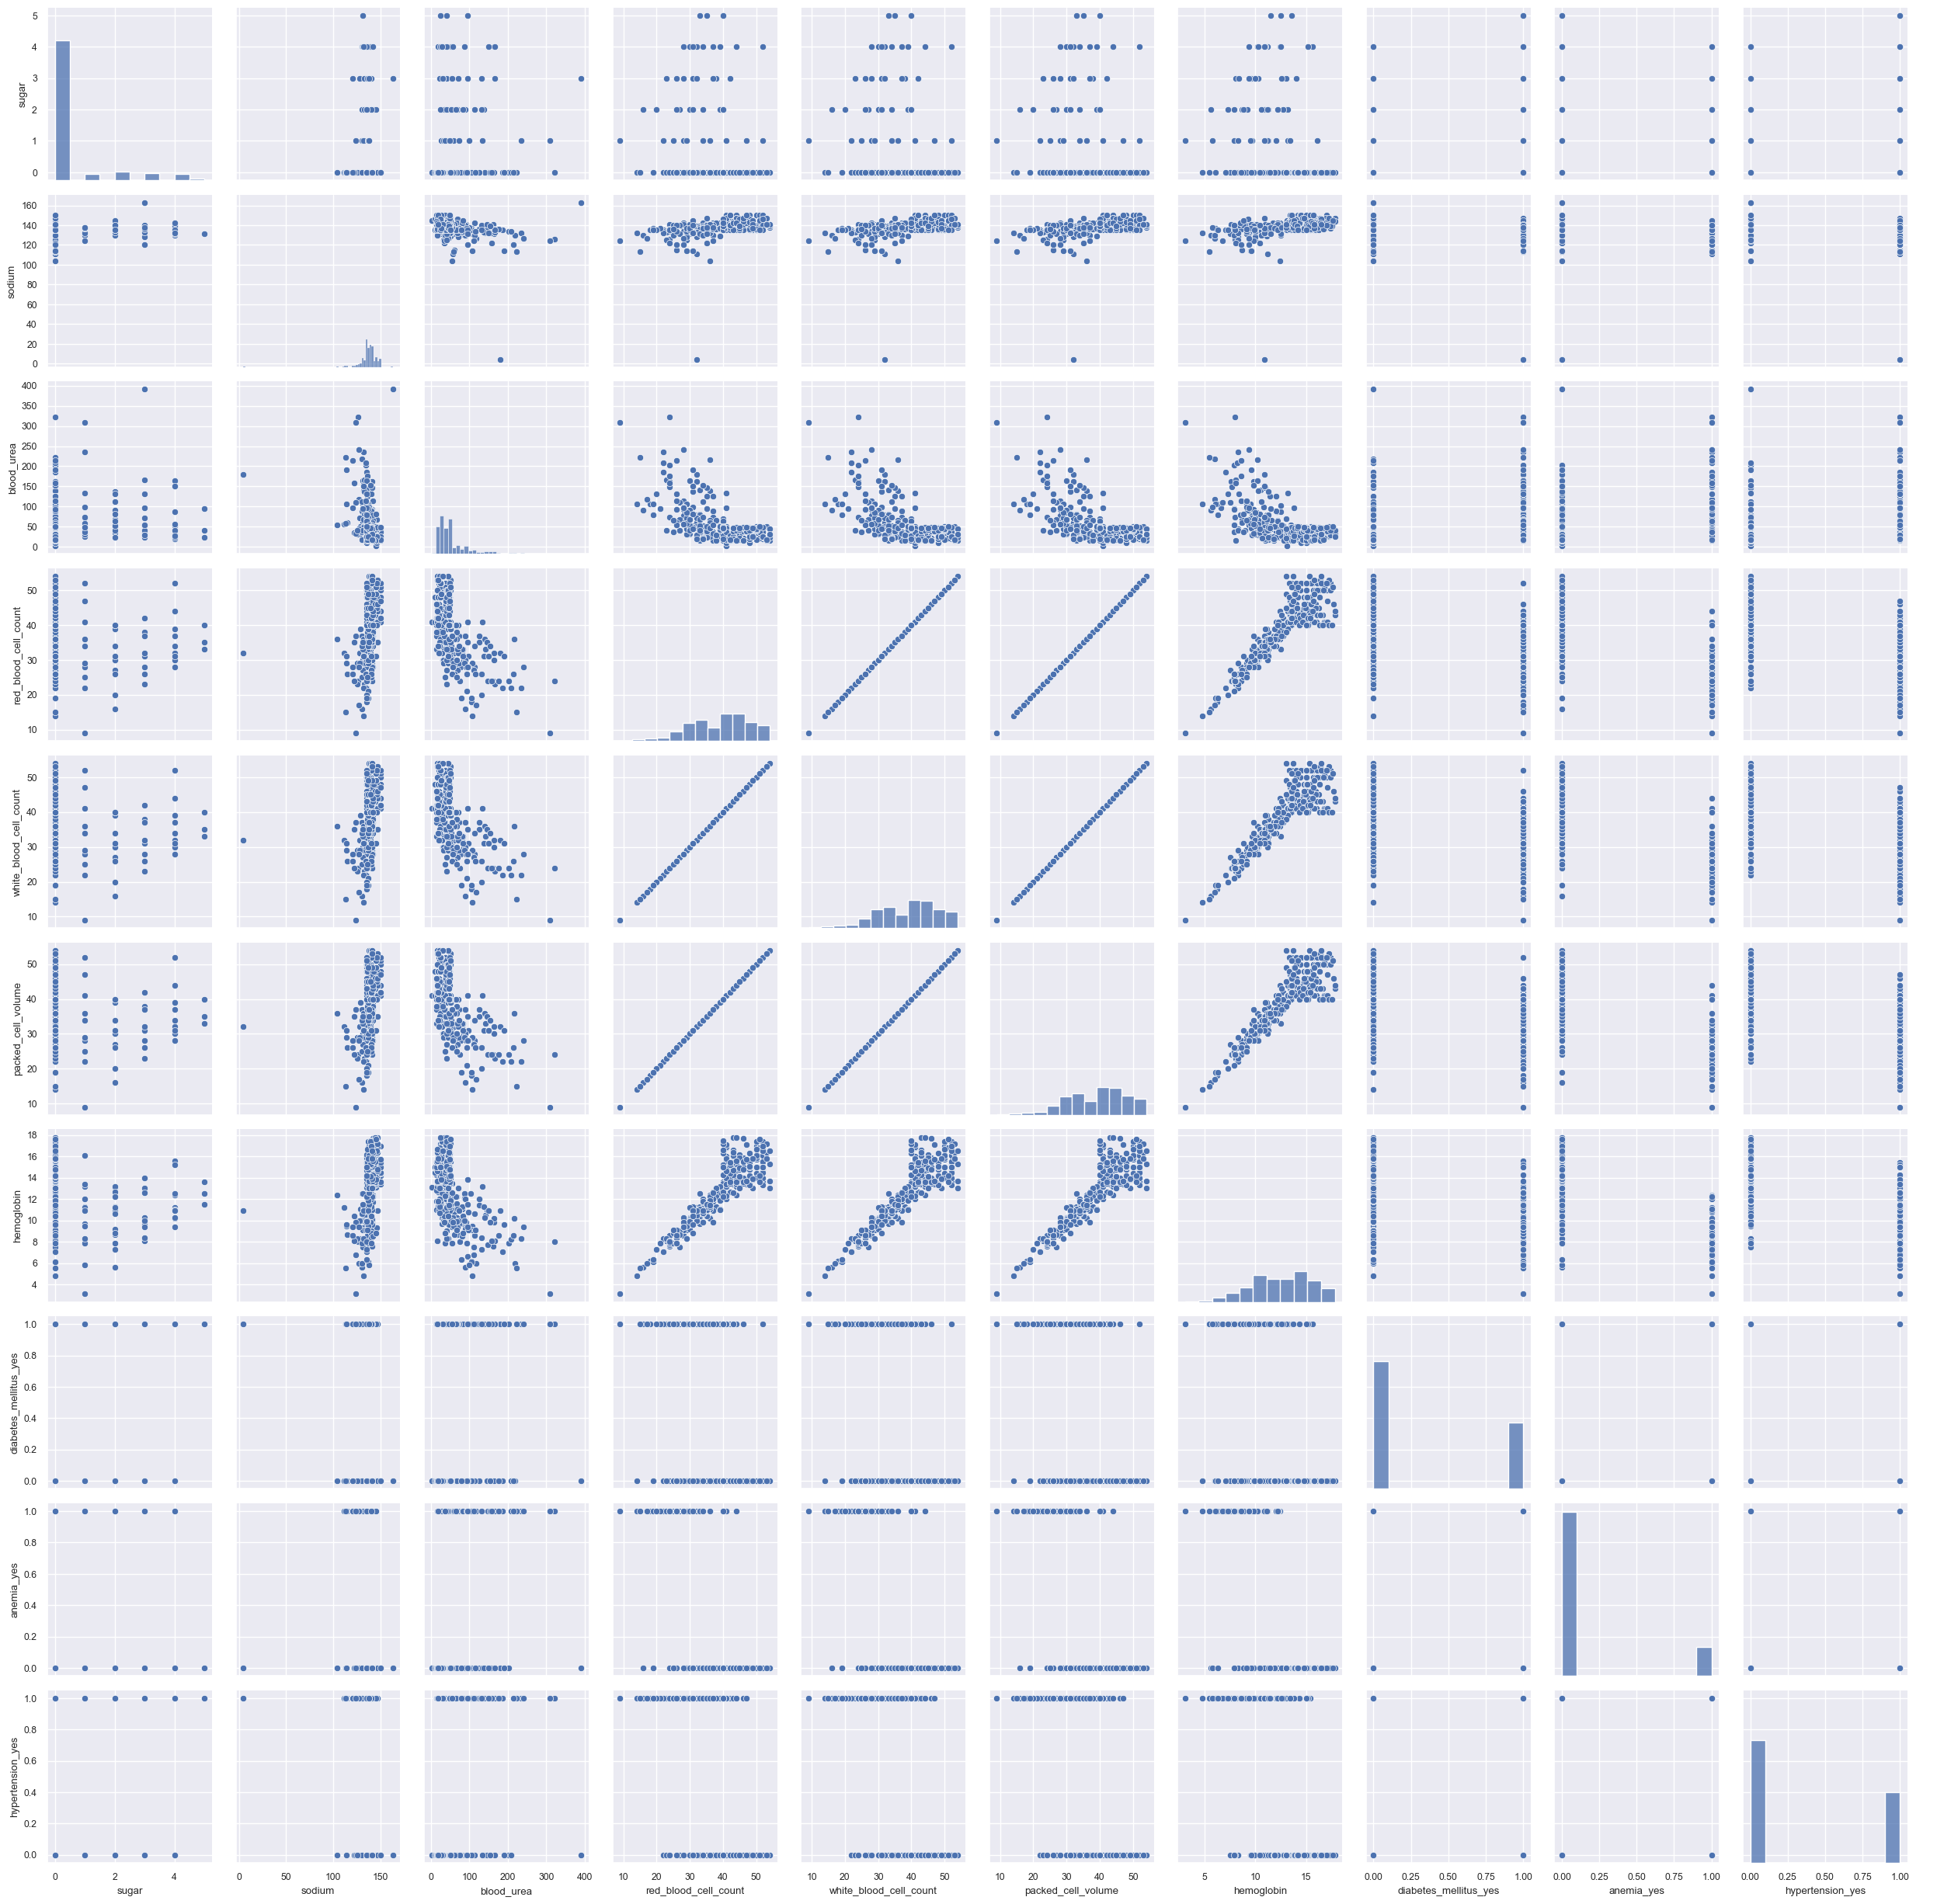

In [275]:
variables = ['sugar', 'sodium', 'blood_urea', 'red_blood_cell_count', 'white_blood_cell_count', 'packed_cell_volume', 'hemoglobin',  'diabetes_mellitus_yes', 'anemia_yes', 'hypertension_yes']
df_high_corr = df[variables]
g = sns.PairGrid(df_high_corr)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [276]:
df.corr(method='pearson')

C:\Users\loren\AppData\Local\Temp\ipykernel_6704\1928163937.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='pearson')


,age,blood pressure,specific_gravity,albumin,sugar,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,hemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension_yes,diabetes_mellitus_yes,coronary_artery_disease_yes,anemia_yes
age,1.000000,0.160836,-0.192609,0.120327,0.222339,0.245221,0.197297,0.133291,-0.098337,0.058301,-0.192928,-0.242119,-0.242119,-0.242119,0.397182,0.366309,0.234191,0.052778
blood pressure,0.160836,1.000000,-0.218347,0.161832,0.222142,0.160286,0.188504,0.145953,-0.117435,0.075248,-0.306540,-0.326319,-0.326319,-0.326319,0.275914,0.233619,0.086399,0.197824
specific_gravity,-0.192609,-0.218347,1.000000,-0.471197,-0.295871,-0.374855,-0.314410,-0.361265,0.413992,-0.072845,0.602582,0.603560,0.603560,0.603560,-0.405953,-0.436853,-0.175644,-0.242699
albumin,0.120327,0.161832,-0.471197,1.000000,0.270442,0.379765,0.453832,0.400092,-0.458410,0.129041,-0.634632,-0.611891,-0.611891,-0.611891,0.526131,0.413782,0.269848,0.322773
sugar,0.222339,0.222142,-0.295871,0.270442,1.000000,0.718065,0.168649,0.223002,-0.133442,0.219580,-0.224775,-0.239189,-0.239189,-0.239189,0.325720,0.527739,0.280213,0.075233
blood_glucose_random,0.245221,0.160286,-0.374855,0.379765,0.718065,1.000000,0.143324,0.114913,-0.267939,0.066947,-0.306189,-0.301385,-0.301385,-0.301385,0.392793,0.528852,0.229624,0.140637
blood_urea,0.197297,0.188504,-0.314410,0.453832,0.168649,0.143324,1.000000,0.586386,-0.323458,0.357070,-0.610360,-0.607621,-0.607621,-0.607621,0.396170,0.319743,0.227105,0.443503
serum_creatinine,0.133291,0.145953,-0.361265,0.400092,0.223002,0.114913,0.586386,1.000000,-0.691248,0.326228,-0.401670,-0.404193,-0.404193,-0.404193,0.280294,0.210399,0.192502,0.239818
sodium,-0.098337,-0.117435,0.413992,-0.458410,-0.133442,-0.267939,-0.323458,-0.691248,1.000000,0.098205,0.365183,0.376914,0.376914,0.376914,-0.346575,-0.306270,-0.236201,-0.227945
potassium,0.058301,0.075248,-0.072845,0.129041,0.219580,0.066947,0.357070,0.326228,0.098205,1.000000,-0.133746,-0.163182,-0.163182,-0.163182,0.064198,0.071086,0.006322,0.115623


High correlation: White blood cell count vs Hemoglobin

- Checking missing values

In [277]:
df.isna().sum()

age                              9
blood pressure                  12
specific_gravity                47
albumin                         46
sugar                           49
red_blood_cells                152
pus_cell                        65
pus_cell_clumps                  4
bacteria                         4
blood_glucose_random            44
blood_urea                      19
serum_creatinine                17
sodium                          87
potassium                       88
hemoglobin                      51
packed_cell_volume              70
white_blood_cell_count          70
red_blood_cell_count            70
appetite                         1
pedal_edema                      1
classification                   0
hypertension_yes                 0
diabetes_mellitus_yes            0
coronary_artery_disease_yes      0
anemia_yes                       0
dtype: int64

In [278]:
df.sort_values(by=['serum_creatinine'], inplace=True, na_position='first')

In [279]:
df_2 = df.sort_values(by=['albumin', 'sugar'], na_position='first')

- Visualization of Missing Values

<Axes: >

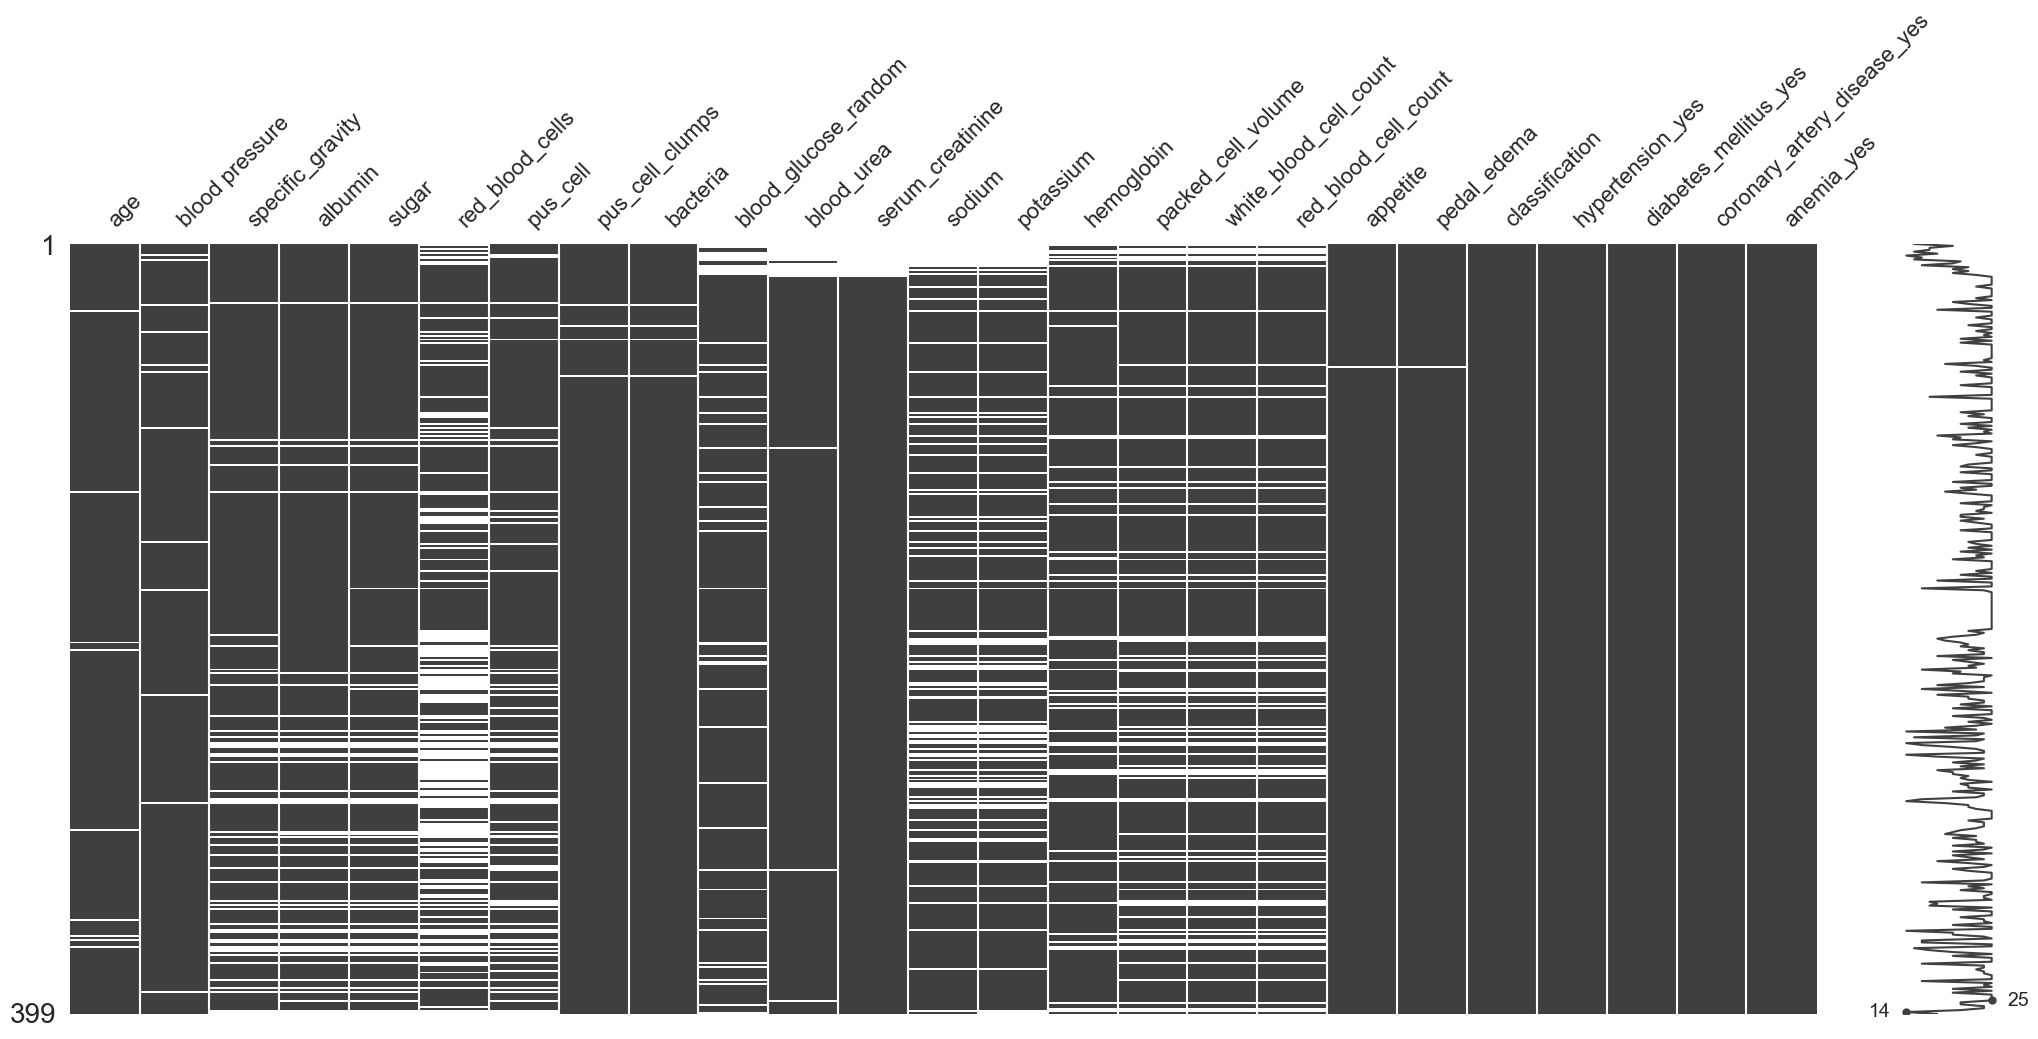

In [280]:
msno.matrix(df)

<Axes: >

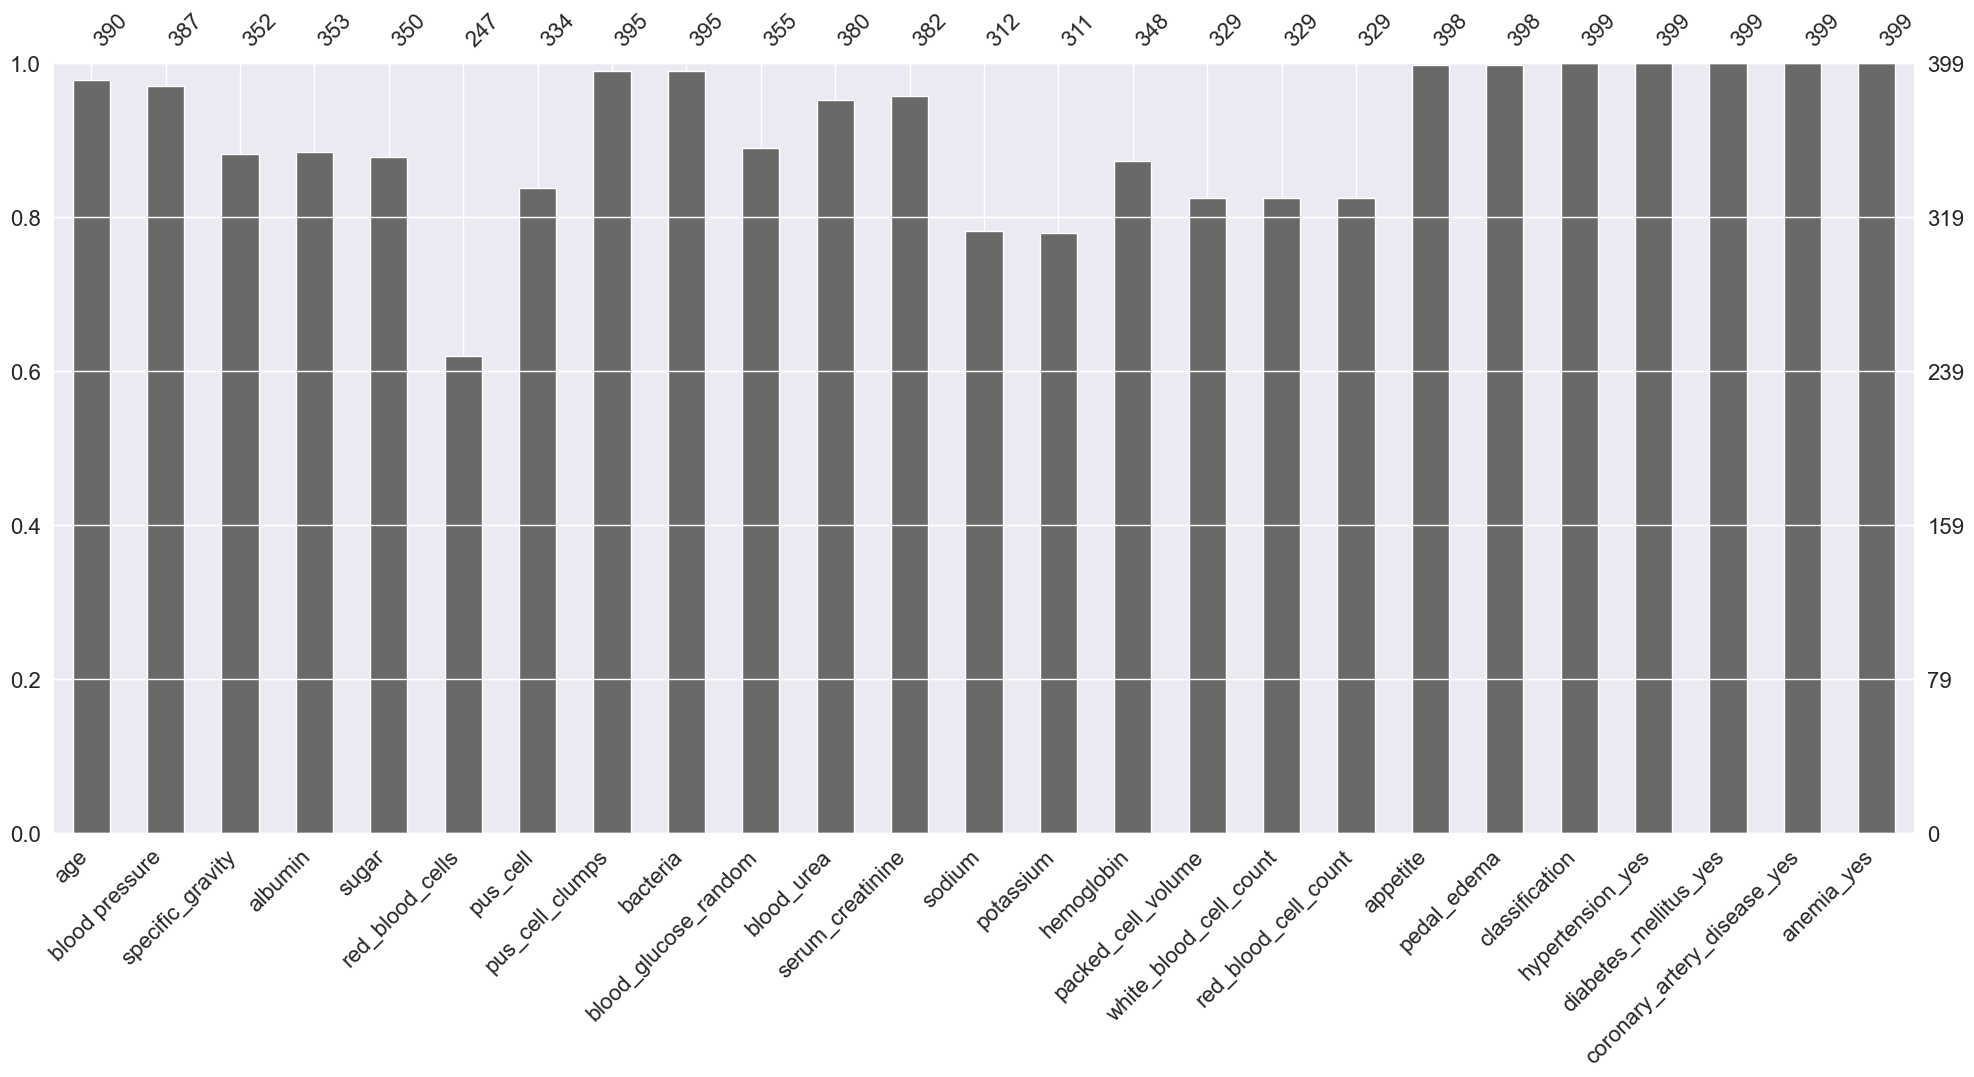

In [281]:
msno.bar(df)

- Visualization of correlation between missing data in each variable

<Axes: >

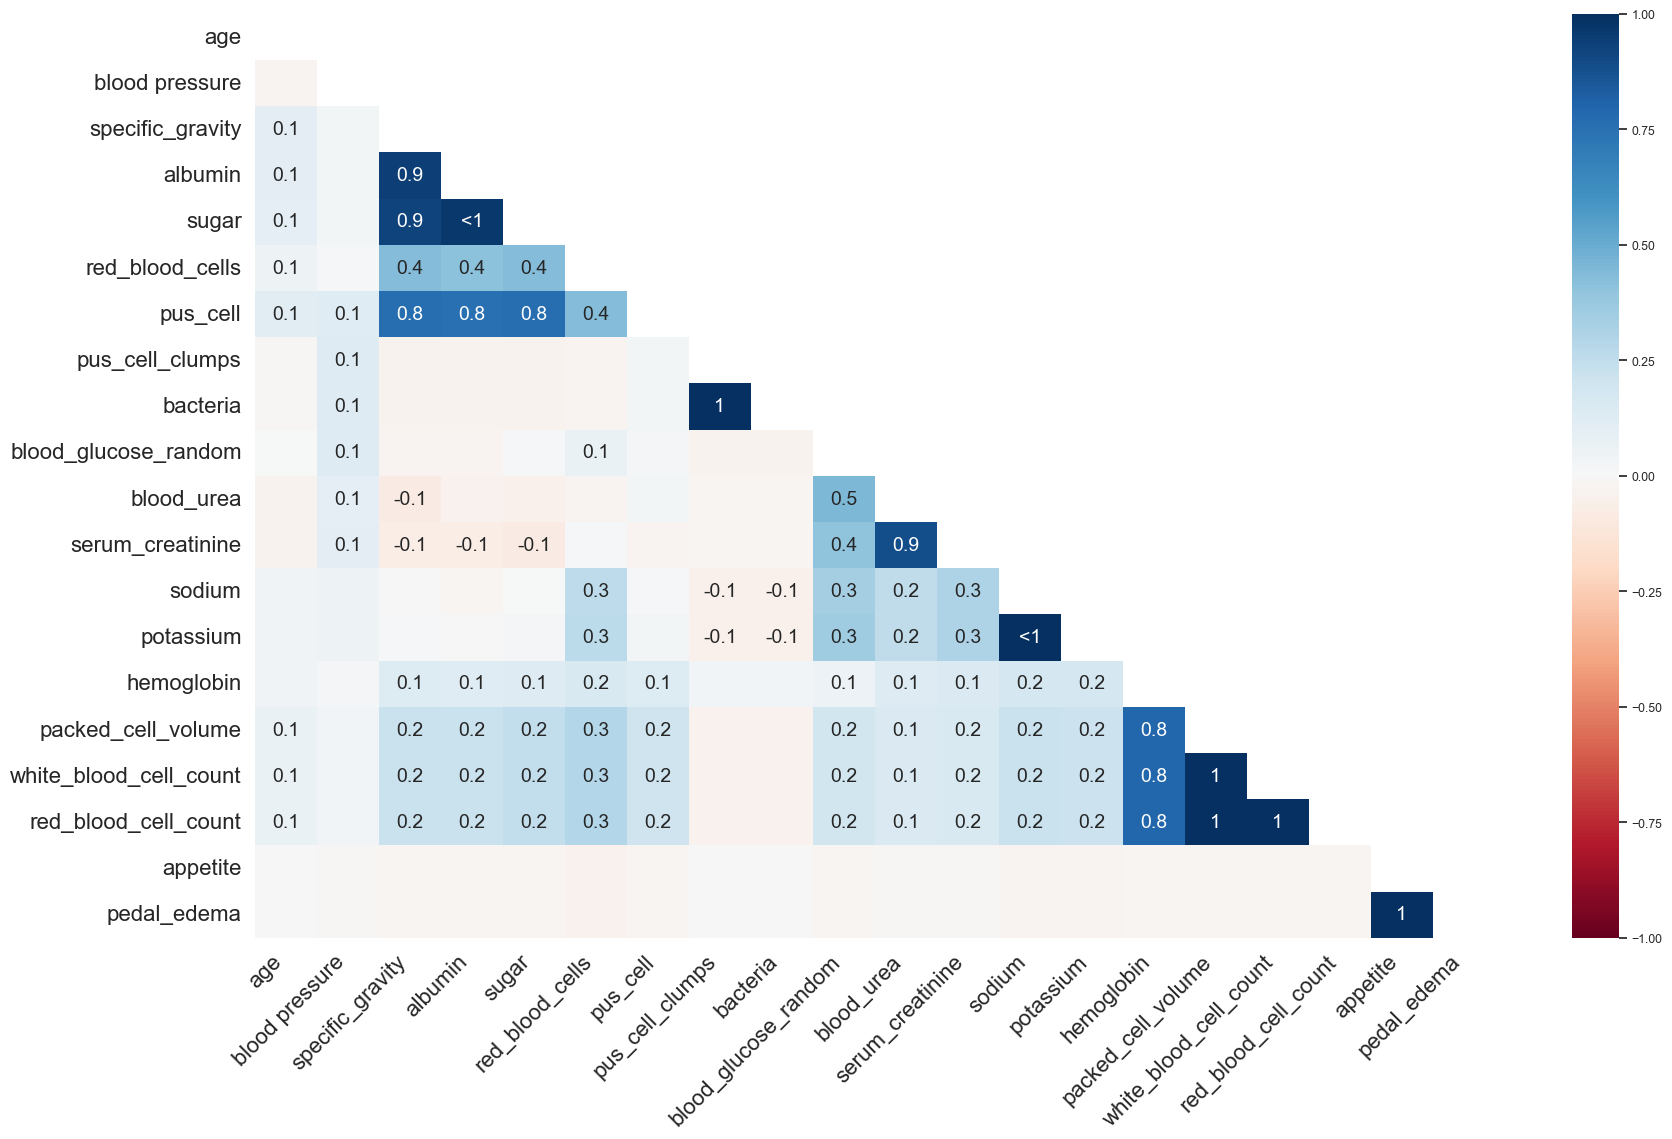

In [282]:
msno.heatmap(df)

**Analysis of Serum Creatinine missing values** <br> 
Serum creatinine is the first and most import variable to be analyzed as this would help to calculate the eGFR*

Looking at the Heatmap the missing values of the Serum Creatinine variable has a strong proportional correlation with the missigness of blood urea variable (BUN). Normally the creatinine test is ordered along with BUN. This evidence some patients didn't take the complete test for Creatinine Test, so it is obvious that both values would be missing. Due to neither Serum Creatinine nor Blood urea are strong correlated with other variables, it is concluded that the missingness mechanism is MCAR. Therefore we can delete the rows with missing values maintaining an unbiased dataset. NaN values of Serum creatinine represent 4,25%

In [283]:
df.dropna(subset=['serum_creatinine'], inplace=True)

**Analysis of missing values in Albumin, Sugar, Specific gravity, Pus cell content** <br> 
By the second matrix graph, a correlation of missing values between Albumin and Sugar content is evident. Also, it is well known that diabetes can compromise the filtration barrier and lead to Albumin filtration in urine. Thus, a Missing At Random (MAR) mechanism is evidenced. To predict missing data, the MICE method is going to be used.

<Axes: >

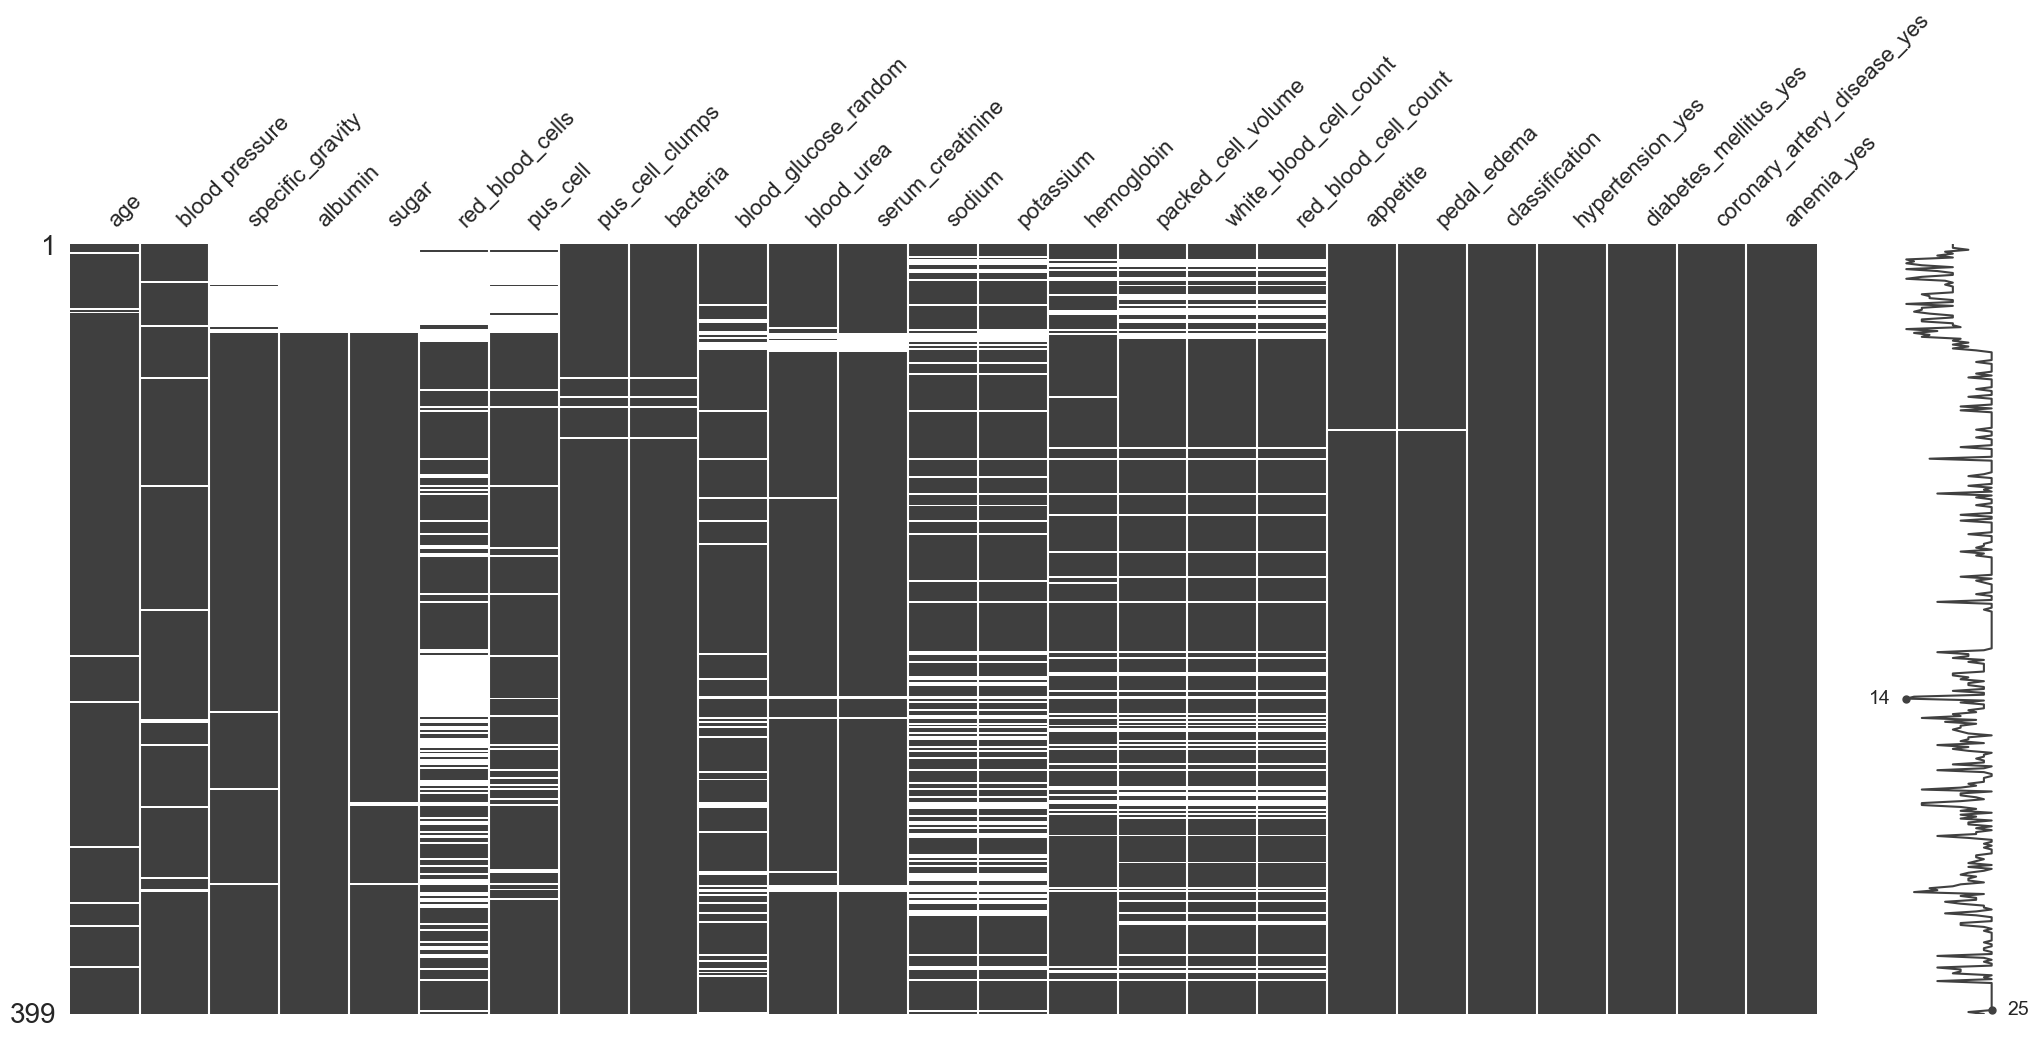

In [284]:
msno.matrix(df_2)

In [285]:
#to have a record of the imputed values
df['null_albumin'] = df['albumin'].isnull()
df['null_sodium'] = df['potassium'].isnull()
df['null_red_blood_cell_count'] = df['red_blood_cell_count'].isnull()
df['null_white_blood_cell_count'] = df['white_blood_cell_count'].isnull()
df['null_packed_cell_volume'] = df['packed_cell_volume'].isnull()
df['null_hemoglobin'] = df['hemoglobin'].isnull()
df['null_blood_urea'] = df['blood_urea'].isnull()

#### Missing data imputation using MICE method (Multivariate Imputation via Chained Equations)

In [286]:
df_numeric = df.select_dtypes(include=['float'])
cols_imputed = df_numeric.columns
print(cols_imputed)
#MICE = multiple imputations 
mice_imputer = IterativeImputer(missing_values=np.nan)
df_imputed = df.copy()
df_imputed[cols_imputed] = mice_imputer.fit_transform(df_numeric)

Index(['age', 'blood pressure', 'specific_gravity', 'albumin', 'sugar',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'hemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count'],
      dtype='object')


Conversion of Albumin predicted values into Nominal values (0,1,2,3,4,5)

In [287]:
df_imputed['albumin'] = df_imputed['albumin'].round(0)

#### Evaluation of imputation results.

1. Descriptive statistical comparison

Descriptive Statistics before imputation

In [288]:
variables = ['albumin', 'sugar', 'sodium', 'blood_urea', 'red_blood_cell_count', 'white_blood_cell_count', 'packed_cell_volume', 'hemoglobin']
df[variables].describe()

,albumin,sugar,sodium,blood_urea,red_blood_cell_count,white_blood_cell_count,packed_cell_volume,hemoglobin
count,336.000000,333.000000,309.000000,379.000000,320.000000,320.000000,320.000000,337.000000
mean,1.026786,0.462462,137.564725,57.544063,38.831250,38.831250,38.831250,12.505935
std,1.356861,1.117739,10.468057,50.589102,9.056923,9.056923,9.056923,2.931514
min,0.000000,0.000000,4.500000,1.500000,9.000000,9.000000,9.000000,3.100000
25%,0.000000,0.000000,135.000000,27.000000,32.000000,32.000000,32.000000,10.300000
50%,0.000000,0.000000,138.000000,42.000000,40.000000,40.000000,40.000000,12.600000
75%,2.000000,0.000000,142.000000,66.000000,45.000000,45.000000,45.000000,15.000000
max,5.000000,5.000000,163.000000,391.000000,54.000000,54.000000,54.000000,17.800000


Descriptive Statistics After imputation

In [289]:
df_imputed[variables].describe()

,albumin,sugar,sodium,blood_urea,red_blood_cell_count,white_blood_cell_count,packed_cell_volume,hemoglobin
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,1.104712,0.480825,137.382083,57.721699,38.831250,38.831250,38.831250,12.512966
std,1.351398,1.092624,10.189168,50.625784,8.287309,8.287309,8.287309,2.760094
min,0.000000,-0.551698,4.500000,1.500000,9.000000,9.000000,9.000000,3.100000
25%,0.000000,0.000000,135.000000,27.000000,34.000000,34.000000,34.000000,10.800000
50%,0.000000,0.000000,138.000000,42.000000,38.831250,38.831250,38.831250,12.684914
75%,2.000000,0.000000,141.000000,66.000000,44.000000,44.000000,44.000000,14.700000
max,7.000000,5.000000,163.000000,391.000000,54.000000,54.000000,54.000000,17.800000


2. Visual Inspection: Visualize if the imputated data follows the pattern with the variables that was high correlated before imputation.

Imputated values of sodium

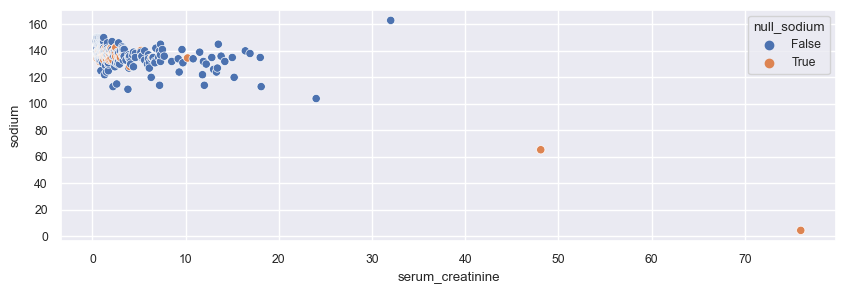

In [290]:
plt.figure(figsize=(10,3))
sns.scatterplot(data=df_imputed, x='serum_creatinine', y='sodium', hue='null_sodium')
plt.show()        

Imputated values of red_blood_cell_count

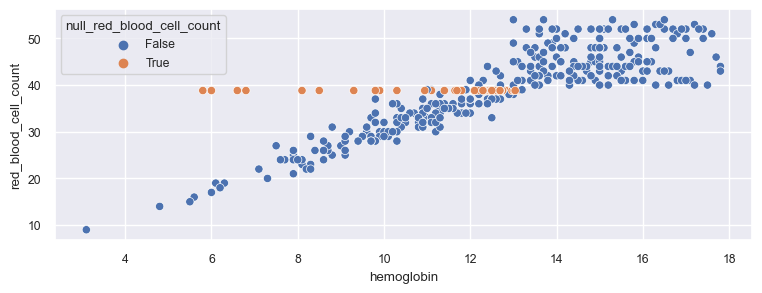

In [291]:
plt.figure(figsize=(9,3))
sns.scatterplot(data=df_imputed, x='hemoglobin', y='red_blood_cell_count',hue='null_red_blood_cell_count')
plt.show()   

Imputated values of Hemoglobin

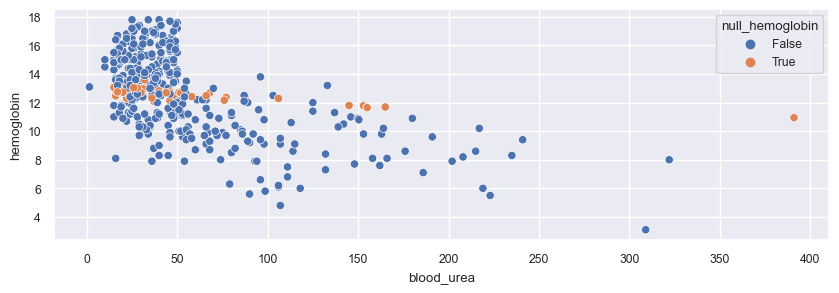

In [292]:
plt.figure(figsize=(10,3))
sns.scatterplot(data=df_imputed, x='blood_urea', y='hemoglobin',hue='null_hemoglobin')
plt.show()   

- Sodium and hemoglobin were well imputed in general, data fitted in the pattern and mean and std remained the same. <br> 
- The red_blood_cell_count didn't showed good imputation in the scatter plot with hemoglobin. std changed 11%. Same applies for white_blood_cell_count and packed_cell_volume

#### Imputing the red blood cells count with another imputing method

Getting the original column (red_blood_cell_count) with null values

In [293]:
df_imputed['red_blood_cell_count'] = df_imputed.apply(lambda x: np.NaN if x['null_red_blood_cell_count'] else x['red_blood_cell_count'], axis=1)
df_imputed['red_blood_cell_count'].isna().sum()

df_imputed['white_blood_cell_count'] = df_imputed.apply(lambda x: np.NaN if x['null_white_blood_cell_count'] else x['white_blood_cell_count'], axis=1)
df_imputed['white_blood_cell_count'].isna().sum()

df_imputed['packed_cell_volume'] = df_imputed.apply(lambda x: np.NaN if x['null_packed_cell_volume'] else x['packed_cell_volume'], axis=1)
df_imputed['packed_cell_volume'].isna().sum()

62

Applying another Imputation methods: IterativeSVD (Singular Value Decomposition), KNN (K-nearest neighbors)

[IterativeSVD] Iter 1: observed MAE=12.285290
[IterativeSVD] Iter 2: observed MAE=6.877572
[IterativeSVD] Iter 3: observed MAE=2.487402
[IterativeSVD] Iter 4: observed MAE=0.188544
[IterativeSVD] Iter 5: observed MAE=0.038087


<Figure size 900x300 with 0 Axes>

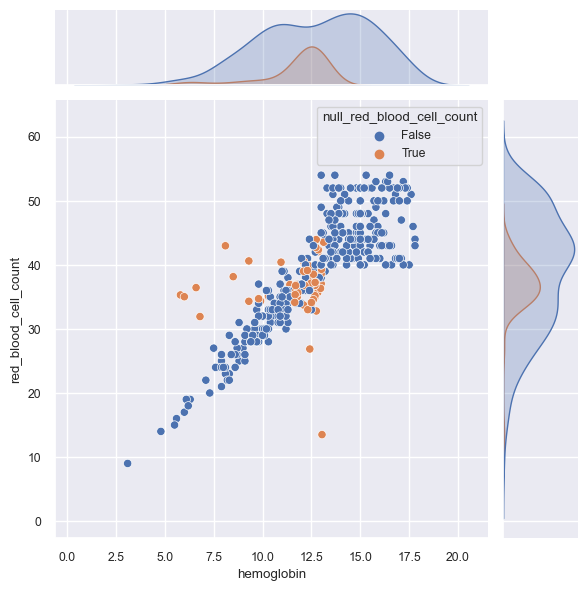

,albumin,sugar,sodium,blood_urea,red_blood_cell_count,white_blood_cell_count,packed_cell_volume,hemoglobin
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,1.104712,0.480825,137.382083,57.721699,38.503290,38.503290,38.503290,12.512966
std,1.351398,1.092624,10.189168,50.625784,8.498910,8.498910,8.498910,2.760094
min,0.000000,-0.551698,4.500000,1.500000,9.000000,9.000000,9.000000,3.100000
25%,0.000000,0.000000,135.000000,27.000000,33.000000,33.000000,33.000000,10.800000
50%,0.000000,0.000000,138.000000,42.000000,39.003314,39.003314,39.003314,12.684914
75%,2.000000,0.000000,141.000000,66.000000,44.000000,44.000000,44.000000,14.700000
max,7.000000,5.000000,163.000000,391.000000,54.000000,54.000000,54.000000,17.800000


In [294]:
df_numeric = df_imputed.select_dtypes(include =['float'])
cols_imputed = df_numeric.columns

imp_svd = IterativeSVD()
df_imputed[cols_imputed] = imp_svd.fit_transform(df_numeric)

plt.figure(figsize=(9,3))
sns.jointplot(data=df_imputed, x='hemoglobin', y='red_blood_cell_count',hue='null_red_blood_cell_count')
plt.show()

df_imputed[variables].describe()

c:\Users\loren\anaconda3\envs\firstenv\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/382 with 0 missing, elapsed time: 0.185
Imputing row 101/382 with 0 missing, elapsed time: 0.190
Imputing row 201/382 with 0 missing, elapsed time: 0.191
Imputing row 301/382 with 0 missing, elapsed time: 0.192


<Figure size 900x300 with 0 Axes>

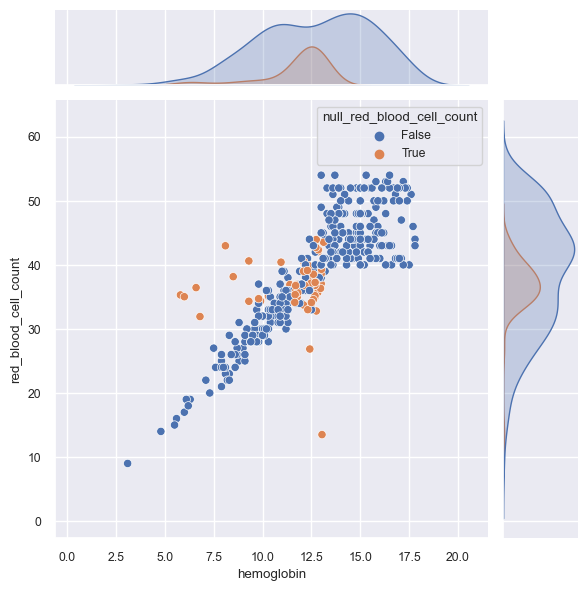

,albumin,sugar,sodium,blood_urea,red_blood_cell_count,white_blood_cell_count,packed_cell_volume,hemoglobin
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,1.104712,0.480825,137.382083,57.721699,38.503290,38.503290,38.503290,12.512966
std,1.351398,1.092624,10.189168,50.625784,8.498910,8.498910,8.498910,2.760094
min,0.000000,-0.551698,4.500000,1.500000,9.000000,9.000000,9.000000,3.100000
25%,0.000000,0.000000,135.000000,27.000000,33.000000,33.000000,33.000000,10.800000
50%,0.000000,0.000000,138.000000,42.000000,39.003314,39.003314,39.003314,12.684914
75%,2.000000,0.000000,141.000000,66.000000,44.000000,44.000000,44.000000,14.700000
max,7.000000,5.000000,163.000000,391.000000,54.000000,54.000000,54.000000,17.800000


In [295]:
df_numeric = df_imputed.select_dtypes(include =['float'])
cols_imputed = df_numeric.columns

imp_svd = KNN()
df_imputed_2 = df_imputed.copy()
df_imputed_2[cols_imputed] = imp_svd.fit_transform(df_numeric)

plt.figure(figsize=(9,3))
sns.jointplot(data=df_imputed_2, x='hemoglobin', y='red_blood_cell_count',hue='null_red_blood_cell_count')
plt.show()
 
df_imputed_2[variables].describe()

In order to improve the performance of IterativeSVD, it was given different values to the attributes init_fill_method and max_iters, nevertheless, the default/initial values of these parameters give the best performance.<br>
<br>
IterativeSVD method resulted in a SVD and mean values really close to the original dataset and looking at the scatterplot figure, the distribution of imputed data keeps the trend of observed data.

### Bivariate Analysis

- Calculation of the estimated glomerular filtration rate (eGFR)

eGFR test helps to define the stage of the disease and will be used as a continuous variable to define if Chronic Kidney disease is present or not. Due to the gender variable is not available, the mean will be used for those variables that depends on gender (k, alpha). Formula was obtained from: https://www.kidney.org/content/ckd-epi-creatinine-equation-2021

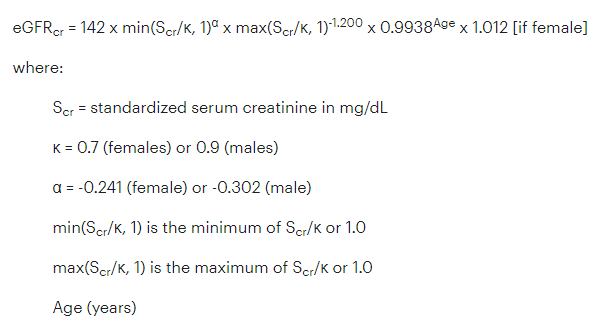
<br>
https://www.kidney.org/content/ckd-epi-creatinine-equation-2021

In [296]:
k = 0.8
alpha = -0.272
#calculate GFR
df_imputed['GFR'] = df_imputed.apply(lambda value: 142*((min(value['serum_creatinine']/k, 1.0))** alpha)*((max(value['serum_creatinine']/k, 1.0))** -1.200)*0.9938**value['age']*1.006, axis =1)
df_imputed['GFR'] = df_imputed['GFR'].round(0)
#establish the classification, the patient has CKD or not
df_imputed['classification_GFR'] = df_imputed.apply(lambda value: 'ckd' if value['GFR'] < 60 else 'notckd', axis =1)
#compare the predicted classification with the one in the dataset
df_imputed['prediction'] = df_imputed.apply(lambda value: True if value['classification'] == value['classification_GFR'] else False, axis =1)
#print estimation
columns_to_plot = ['age', 'serum_creatinine', 'GFR', 'classification', 'classification_GFR', 'prediction']
df_imputed[columns_to_plot].head(4)

trues = df_imputed[df_imputed['prediction'] == True]['prediction'].count()
estimation = round((trues/len(df_imputed))*100, 0)

print('The Classification variable was correctly estimated in: ' + str(estimation) + '%')

The Classification variable was correctly estimated in: 88.0%


#### Checking the correlation between variables and eGFR

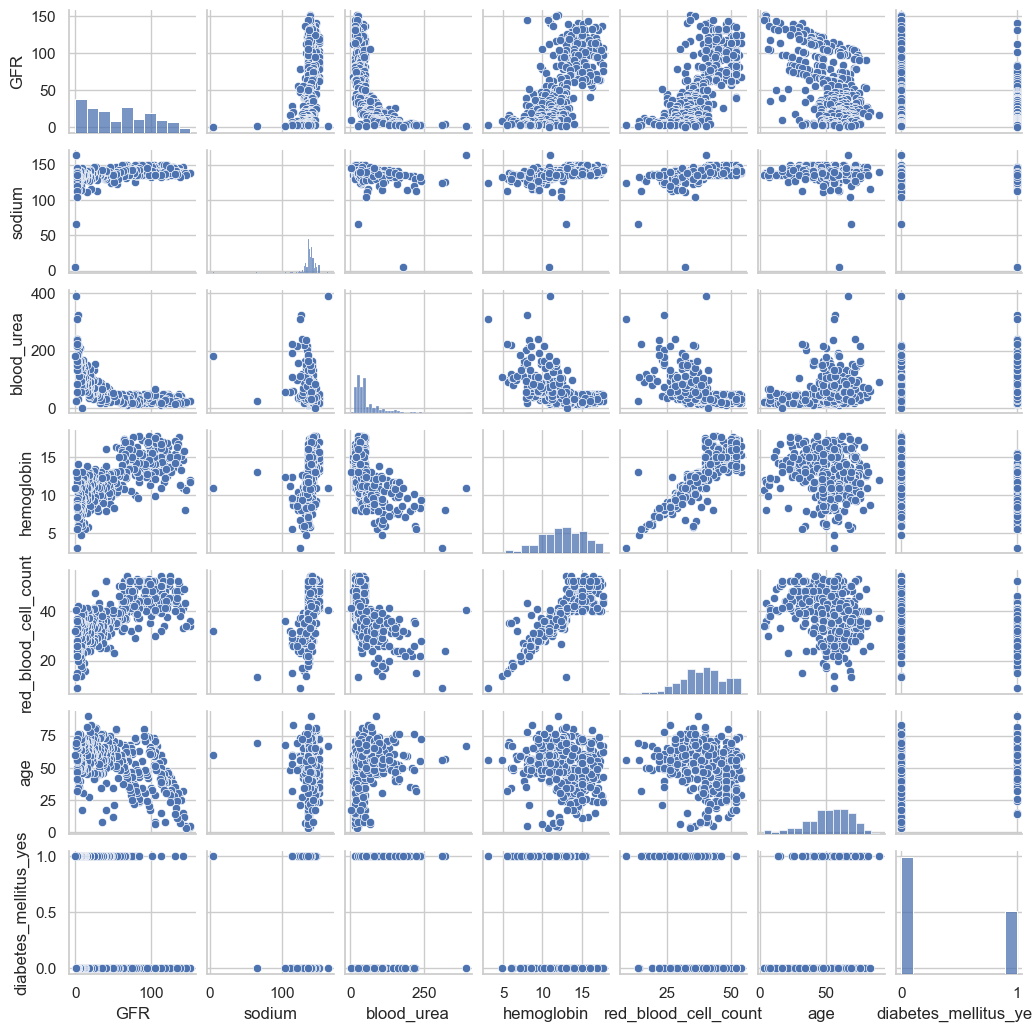

In [341]:
sns.set(style='whitegrid', context='notebook')
cols=['GFR','sodium', 'blood_urea', 'hemoglobin', 'red_blood_cell_count', 'age', 'diabetes_mellitus_yes']
sns.pairplot(df_imputed[cols], height=1.5)

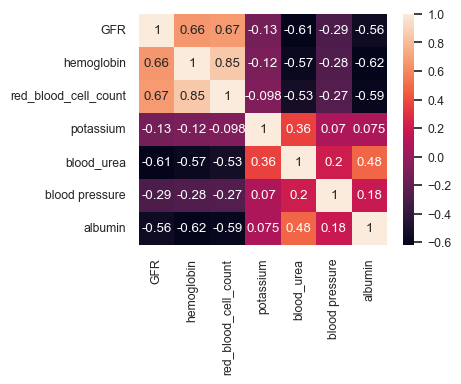

In [298]:
cols=['GFR', 'hemoglobin', 'red_blood_cell_count', 'potassium', 'blood_urea', 'blood pressure', 'albumin']
cm = np.corrcoef(df_imputed[cols].values.T)
plt.figure(figsize=(4,3))
sns.set(font_scale=0.8)
sns.heatmap(cm, cbar= True, annot=True, yticklabels=cols, xticklabels=cols)
plt.show()

- GFR has a medium to high correlation with variables Red blood cell count, Blood Urea, albumin, blood pressure
- Red blood cell count has the lowest correlation with blood pressure. These two variables will be used for the Multivariate Lineal Regression 

## Bivariate lineal Regression model

In [299]:
#giving a 2D shape to the x, y variables
x = df_imputed['hemoglobin'].values.reshape(-1,1) 
y = df_imputed['GFR'].values.reshape(-1,1)
#initialization of the StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
#standarization of the data to have the same scale and become less sensitive to outliers
x_std = sc_x.fit_transform(x)
y_std = sc_y.fit_transform(y)
#standard lineal regression 
slr = LinearRegression()
slr.fit(x_std, y_std)
y_pred = slr.predict(x_std)
r2 = r2_score(y_std, y_pred)
print('r2: ', r2.round(4))

r2:  0.4298


Text(0.5, 0, 'Hemoglobin')

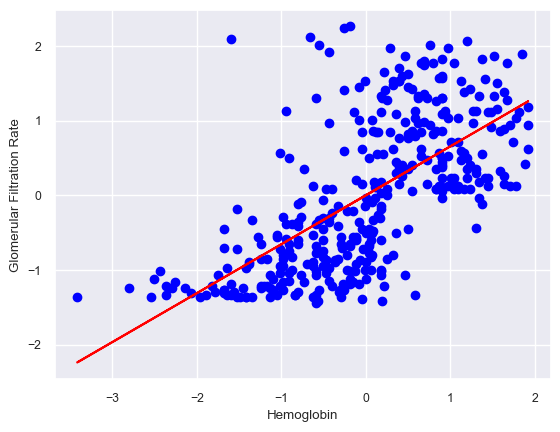

In [300]:
plt.scatter(x_std, y_std, color='blue')
plt.plot(x_std, slr.predict(x_std), color='red')
plt.ylabel("Glomerular Filtration Rate")
plt.xlabel("Hemoglobin")

## Multivariate Lineal Regression

- Red blood cell count is the variables with higher correlation with GFR and the lowest with blood pressure.
- Hemoglobin and red blood cells count will not be used in order to prevent colineality, as these two are highly correlated (0.85).

In [342]:
X = df_imputed[['blood_urea', 'hemoglobin', 'red_blood_cell_count']]
y = df_imputed['GFR'].values.reshape(-1,1)

In [343]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.8, random_state=0)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

c:\Users\loren\anaconda3\envs\firstenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\loren\anaconda3\envs\firstenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


#### Quantifying the quality of predictions and model

In [344]:
r2 = r2_score(y_test, y_pred)
#Root mean squared error (RMSE): average distance between the observed data and the predicted data
rmse = mean_squared_error(y_test, y_pred)

columns_names = X.columns
x =0
for column in columns_names:
    x = x+1
    print(f'Variable{x}: {column}')
    
print('r2: ', r2.round(4))
print('rmse : ', rmse.round(4))

Variable1: blood_urea
Variable2: hemoglobin
Variable3: red_blood_cell_count
r2:  0.5133
rmse :  0.4826


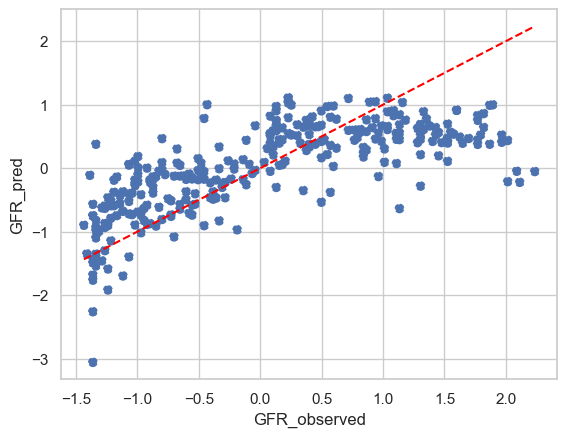

In [345]:
plt.scatter(y_test, y_pred, linestyle='--')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('GFR_observed')
plt.ylabel('GFR_pred')
plt.show()

Previous R2 for different regressions: <br>

red_blood_cell_count,  blood_urea, r2:  0.5107 <br>
blood_urea, albumin, r2:  0.4202 <br>
red_blood_cell_count, albumin, r2:  0.3798 <br>
blood_urea, potassium, r2:  0.3088 <br>
'red_blood_cell_count', 'blood pressure', R2: 0.33 <br>
'blood_urea', 'blood pressure', R2: 0.33 <br>
red_blood_cell_count, potassium r2:  0.3314 <br>
'albumin', 'blood pressure', R2: 0.29 <br>
potassium, albumin, r2:  -0.0803 <br>
potassium, blood pressure, R2: -0,38 <br>
- 'blood_urea', 'hemoglobin', 'red_blood_cell_count', 'albumin', r: 0,51 (Eliminar Albumin por su alto valor p)


In [346]:
columns = X.columns
model.intercept_= model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)
y_test = y_test.reshape(-1)

print("----------------------------Sumary-----------------------------")
stats.summary(model, X_test, y_test, columns)

----------------------------Sumary-----------------------------
Residuals:
    Min      1Q  Median     3Q    Max
-2.3355 -0.4258  0.0794 0.4659 1.7164


Coefficients:
                      Estimate  Std. Error  t value   p value
_intercept           -0.009131    0.039726  -0.2299  0.818359
blood_urea           -0.194812    0.048109  -4.0494  0.000065
hemoglobin            0.242967    0.071371   3.4043  0.000752
red_blood_cell_count  0.359992    0.072493   4.9659  0.000001
---
R-squared:  0.51326,    Adjusted R-squared:  0.50843
F-statistic: 106.15 on 3 features


c:\Users\loren\anaconda3\envs\firstenv\lib\site-packages\regressors\stats.py:144: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  X1 = np.hstack((np.ones((n, 1)), np.matrix(X)))
c:\Users\loren\anaconda3\envs\firstenv\lib\site-packages\numpy\matrixlib\defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
c:\Users\loren\anaconda3\envs\firstenv\lib\site-packages\regressors\stats.py:144: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/num

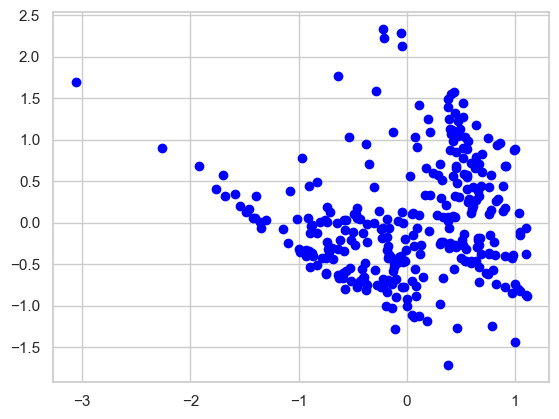

In [347]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals, color='blue')
plt.show()